In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint

# time series specific
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    CutoffSplitter,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

from dsf_utils.preprocessing import process_raw_data, single_region_ts
from dsf_utils.evaluation import evaluate_forecasters_on_cutoffs, display_results
from dsf_utils.plotting import plot_cv_results
# custom model from:
# https://www.sktime.org/en/latest/developer_guide/add_estimators
from dsf_utils.models import ConstantValueForecaster

# warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (20,10)})
# set the numpy seed
np.random.seed(99)

# Data

In [3]:
# California time series
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")
main_df = process_raw_data(main_df)
ts = single_region_ts(main_df, region="California")

# The rules of the game

We will assess the performance of the forecasting algorithms using a fixed length training window test performance of a 3-week ahead forecast in the following 8 cutt-off points:
* off-season: 2018-07-01, 2019-07-01
* flu-season start: 2018-10-01, 2019-09-01
* flus-season peak: 2018-12-15, 2019-11-24
* flu-season end: 2019-03-01, 2019-05-01

We'll evaluate forecast based on **RMSSE** and use naive forecasters as a baseline

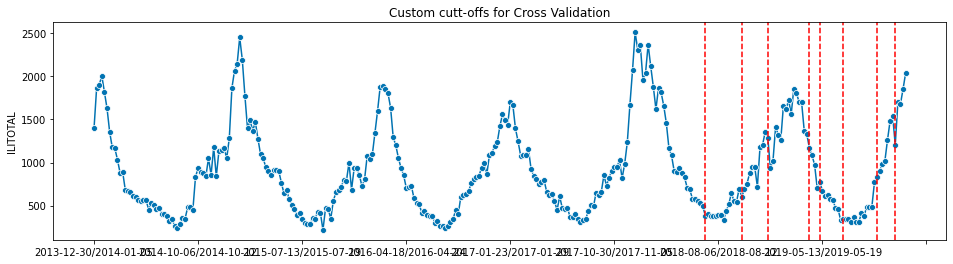

In [4]:
custom_cutoffs = np.array([
    len(ts[ts.index <= date]) 
    for date in 
    [
        # off-season
        "2018-07-01", 
        "2019-07-01", 
        # season start
        "2018-10-01", 
        "2019-10-01", 
        # season peak
        "2018-12-15", 
        "2019-11-24", 
        # season end
        "2019-04-01", 
        "2019-05-01"
    ]
])

# create the CV object
CV = CutoffSplitter(
    # custom cuttoffs
    cutoffs=custom_cutoffs, 
    # 3 step ahead forecast
    fh=np.arange(3)+1,
    # 5 years of training data
    window_length=5*52,
)

metric = MeanSquaredScaledError(square_root=True)

plot_series(ts)
for cutoff in custom_cutoffs: 
    plt.axvline(cutoff, color="red", linestyle="--")
plt.title("Custom cutt-offs for Cross Validation")
plt.show()

# Naive Benchmarks

In [5]:
forecasters_dict = {
    "Seasonal Naive": NaiveForecaster(sp=52), 
    "Naive": NaiveForecaster(sp=1)
}
metrics_dict = {"RMSSE": metric}
eval_df = evaluate_forecasters_on_cutoffs(ts, custom_cutoffs, forecasters_dict, metrics_dict)
display_results(eval_df)

Metric,RMSSE
Forecaster,
Naive,1.33
Seasonal Naive,1.97


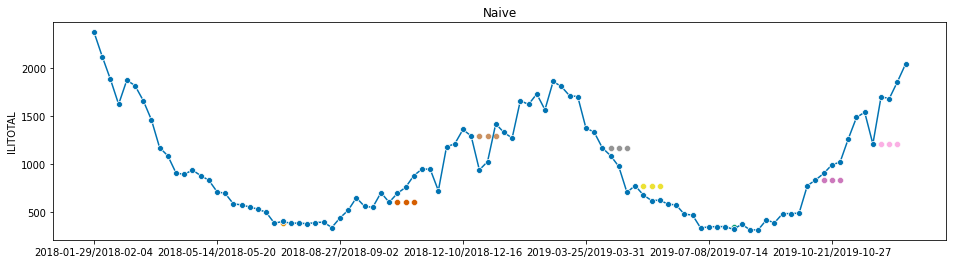

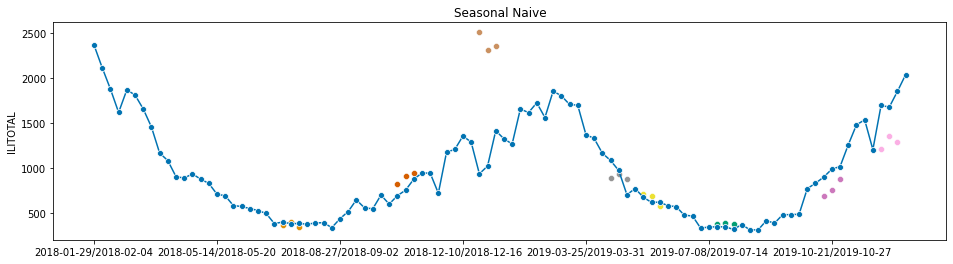

In [6]:
plot_cv_results(ts.iloc[-100:], eval_df)

# Statisitcal Forecasting Methods

## Exponential Smoothing

**Forecasting Principles and Practice - Exponential Smoothing chapter introduction:**  
Exponential smoothing was proposed in the late 1950s (Brown, 1959; Holt, 1957; Winters, 1960), and has motivated some of the most successful forecasting methods. Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight. This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry.  

**Exponential Smooting (ETS)** in it's simplest form **Simple Exponential Smoothing (SES)** is defined as:  
(insert formula )

The relatively new **Innovations State Space approach** (introduced in the ealry 2000s) for exponential smoothing has provided the statistical framework that the exponential smoothing lacked in the past. Under the innovations state space approaches exponential smooting methodas are capable of generating prediction intervals and much more.  

Under the state space approach there are 36 possible models: 

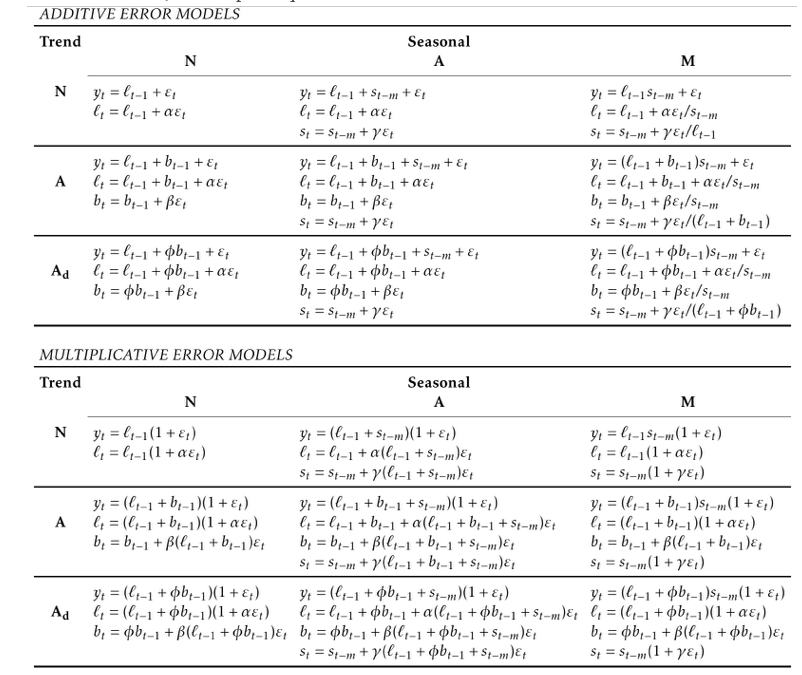

**Model selection** can be done either through cross-validation i.e. test all models and pick the best in a cross validation framework or through the use of information criteria. The most common Infromation Criteria used are:
* Akaike Information Criterion - AIC
* corrected Akaike Information Criterion - AICc
* Bayesian Information Criterion - BIC

For the above ICs - you can think of ICs as SSE with a penalty for number of fitted parameters of a model. For example, if SES and ETS(A,A,A) achieve the same SSE for a time series, then the model with the smallest IC will be SES as it achieves the same SSE with less parameters. The best model is the one that minimises the chosen IC.

The 2008 paper [“Automatic Time Series Forecasting: The forecast Package for R” by R. J. Hyndman and Y. Khandakar](https://www.jstatsoft.org/article/view/v027i03) introduced the automatic model selection with ICs methods and the famous [forecast R package](https://cran.r-project.org/web/packages/forecast/forecast.pdf). The majority of the python implementations are mimicking the forecast package in R.

You can listen to the story behind the automatic ETS algorithm and how it saved the Australian goverment Millions of dollars in Prof. Rob Hyndman's recent webinar -> [Uncertain futures: what can we forecast and when should we give up?](https://www.youtube.com/watch?v=YOeDTt_JJx0&t=3s)  

References:  
1. [Forecasting Principles and Practice - Section 8](https://otexts.com/fpp3/ses.html)
2. [Forecasting with exponential smoothing: The state space approach](https://robjhyndman.com/expsmooth/)

Metric,RMSSE
Forecaster,
AutoETS - AIC,1.07
AutoETS - AICc,1.07
AutoETS - BIC,0.99


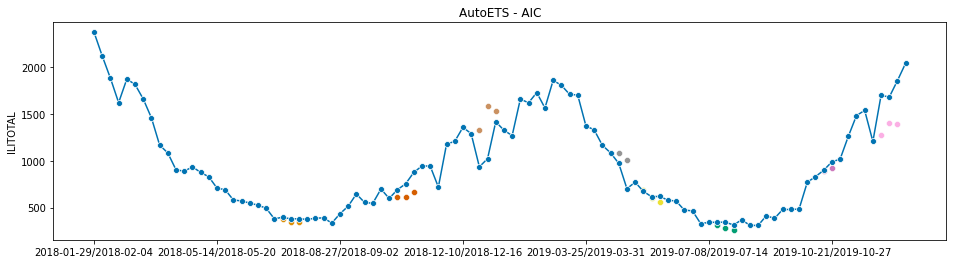

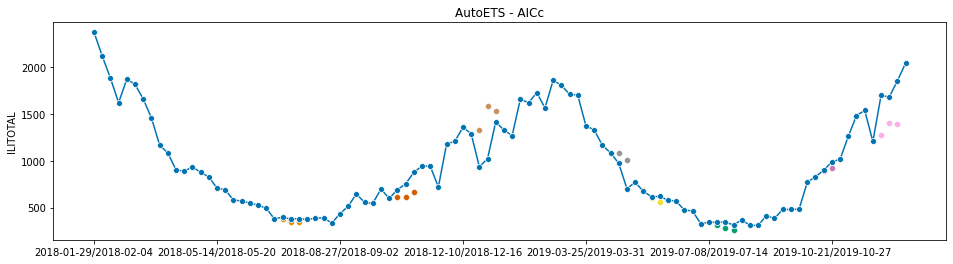

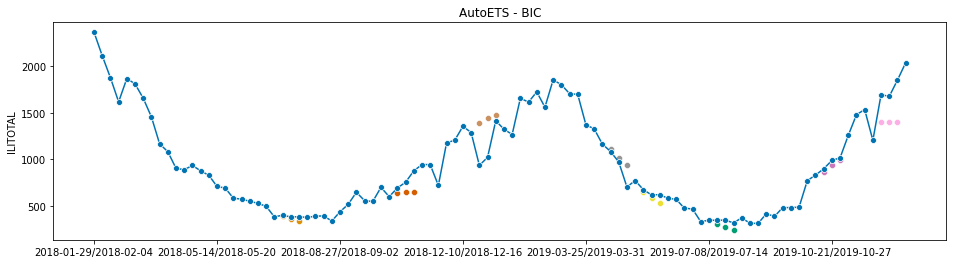

In [7]:
metric = MeanSquaredScaledError(square_root=True)

forecasters_dict = {
    "AutoETS - AICc": AutoETS(auto=True, sp=52, information_criterion="aicc"), 
    "AutoETS - BIC": AutoETS(auto=True, sp=52, information_criterion="bic"),
    "AutoETS - AIC": AutoETS(auto=True, sp=52, information_criterion="aic"),
}
metrics_dict = {"RMSSE": metric}
eval_df = df = evaluate_forecasters_on_cutoffs(ts, custom_cutoffs, forecasters_dict, metrics_dict)

display_results(eval_df)

plot_cv_results(ts.iloc[-100:], eval_df)

## Other Stat. Forecasting Algorithms

* **ARIMA:** Autoregressive Integrated Moving Average. [FPP chapter 9](https://otexts.com/fpp3/arima-ets.html)
* **TBATS:** Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal. This medium article gives a nice introduction to TBATS: https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

**ARIMA vs ETS:**
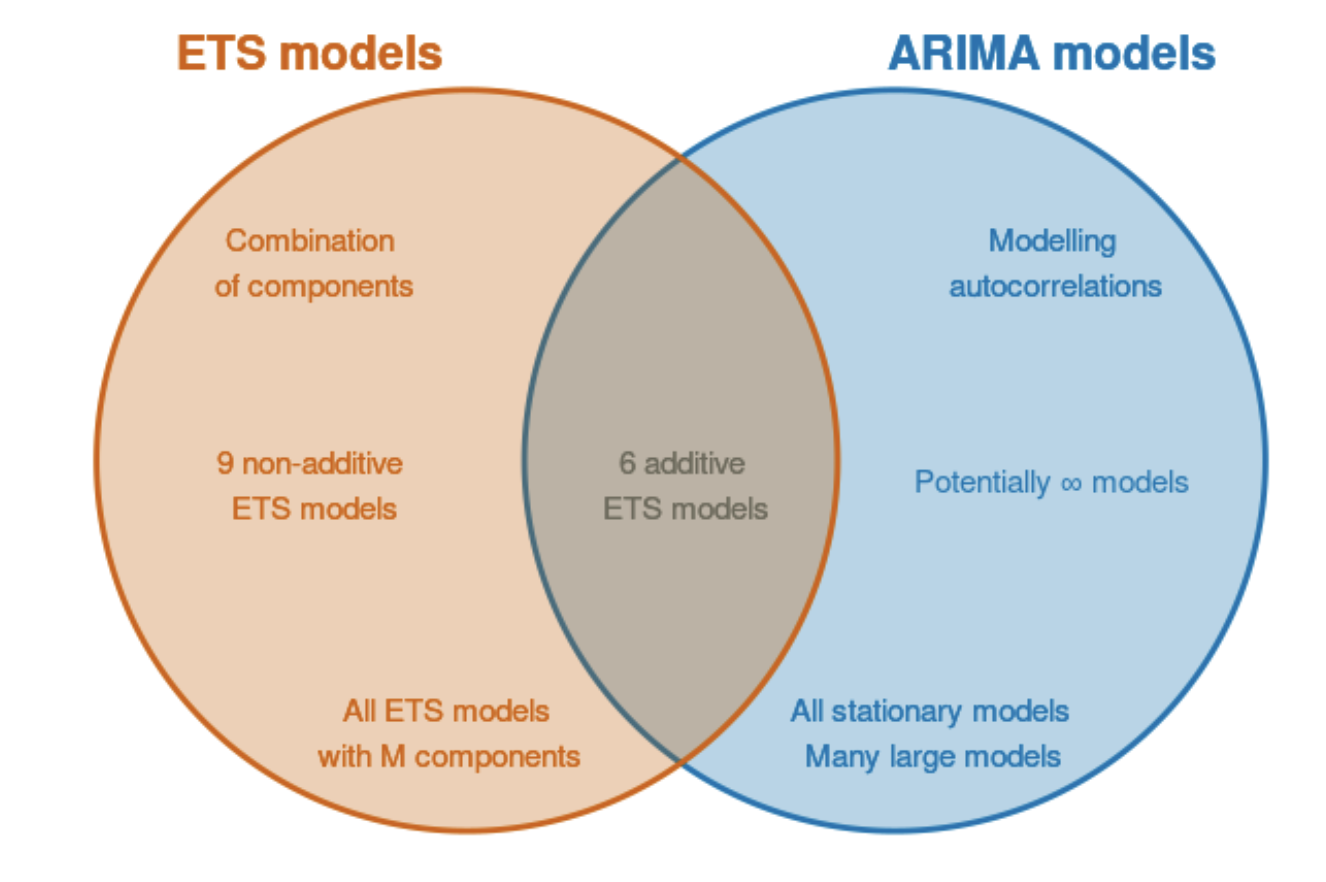

image from:  
https://otexts.com/fpp3/arima-ets.html

# Forecasting Pipelines with sktime

In [FPP section 13.1](https://otexts.com/fpp3/weekly.html) the authors suggest that seaonal periods of weekly, daily, hourly etc. data are to large for ETS and ARIMA. They suggest 2 approaches:
1. Use Fourier Features as exogenous variables
2. Do an STL transformation and fit an ARMA or SES model on the residuals
3. Use TBATS - Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal. This medium article gives a nice introduction to TBATS: https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

Another common approach is to combine forecasts with the Box-Cox transformation to stabilise the variance of the time series. There's a nice interactive plot here: https://otexts.com/fpp3/transformations.html

Metric,RMSSE
Forecaster,
STL - SES,1.33
TBATS,0.87
boxcox - STL - ARMA,1.10
boxcox - STL - SES,1.08
log - AutoETS,1.04
log - STL - SES,1.08


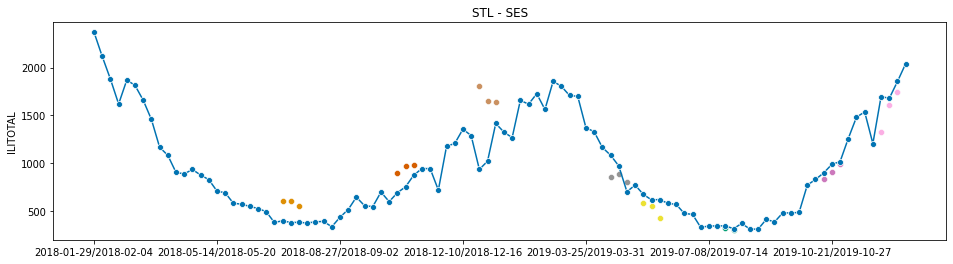

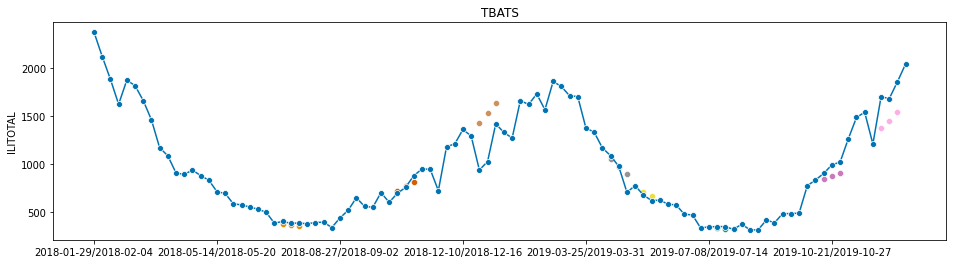

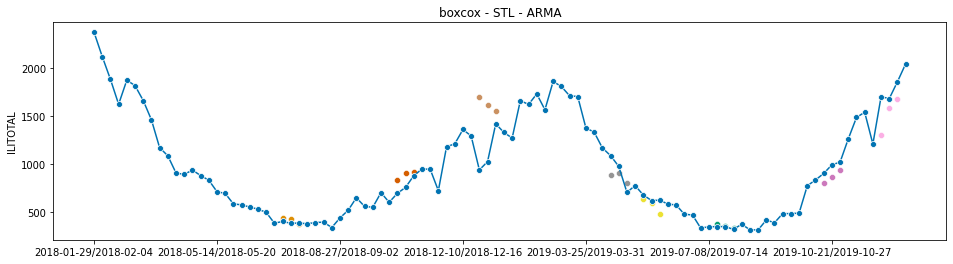

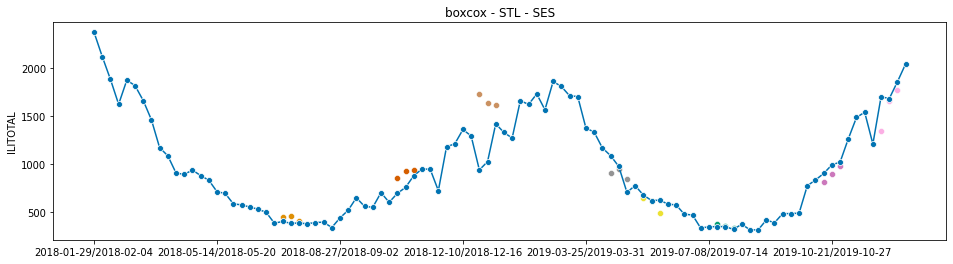

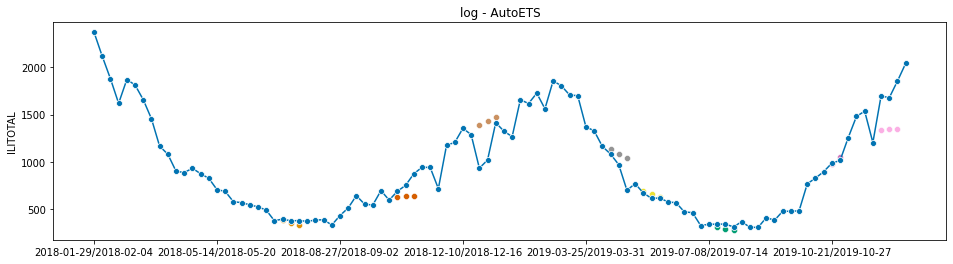

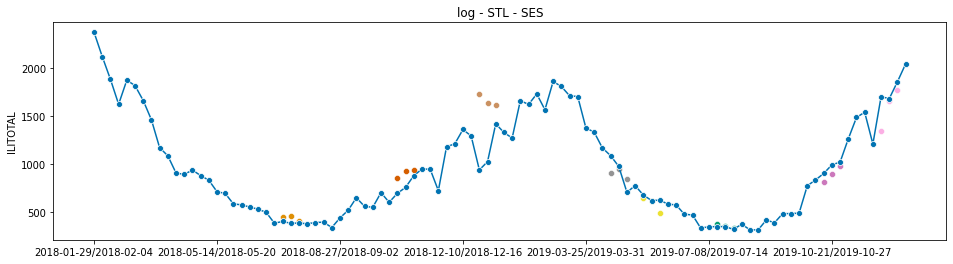

In [8]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import STLTransformer
from sktime.transformations.series.boxcox import LogTransformer, BoxCoxTransformer
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.arima import AutoARIMA

forecasters_dict = {
    "STL - SES": TransformedTargetForecaster([
        ("stl", STLTransformer(sp=52)),
        ("ses", AutoETS(error="add", trend=None, seasonal=None))
    ]),
    "log - STL - SES": TransformedTargetForecaster([
        ("log", LogTransformer()),
        ("stl", STLTransformer(sp=52)),
        ("ses", AutoETS(error="add", trend=None, seasonal=None))
    ]),
    "boxcox - STL - SES": TransformedTargetForecaster([
        ("log", BoxCoxTransformer(bounds=(0,1), method="guerrero", sp=52)),
        ("stl", STLTransformer(sp=52)),
        ("ses", AutoETS(error="add", trend=None, seasonal=None))
    ]),
    "log - AutoETS": TransformedTargetForecaster([
        ("log", LogTransformer()),
        ("auto-ets", AutoETS(auto=True, sp=52, information_criterion="bic")),
    ]),
    "TBATS": TBATS(sp=52),
    "boxcox - STL - ARMA": TransformedTargetForecaster([
        ("log", BoxCoxTransformer(bounds=(0,1), method="guerrero", sp=52)),
        ("stl", STLTransformer(sp=52)),
        ("arma", AutoARIMA(sp=False, seasonal=False, d=0))
    ]),
}
metrics_dict = {"RMSSE": metric}

eval_df = evaluate_forecasters_on_cutoffs(ts, custom_cutoffs, forecasters_dict, metrics_dict)

display_results(eval_df)

plot_cv_results(ts.iloc[-100:], eval_df)

## Forecast Combinations

Another common practice in forecasting is to take combinations of forecasts as the final forecast. Taking simply the average works well, as shown in the most recent M competition (M5). 

In [FPP section 13.4](https://otexts.com/fpp3/combinations.html) they go as far as claiming the following:  
*The results have been virtually unanimous: combining multiple forecasts leads to increased forecast accuracy. In many cases one can make dramatic performance improvements by simply averaging the forecasts.*


In [6]:
from sktime.forecasting.compose import EnsembleForecaster

forecasters_dict = {
    "potpourri": EnsembleForecaster([
        ("log - STL - SES", TransformedTargetForecaster([
            ("log", LogTransformer()),
            ("stl", STLTransformer(sp=52)),
            ("ses", AutoETS(error="add", trend=None, seasonal=None))
        ])),
        ("AutoETS", AutoETS(auto=True, sp=52, information_criterion="bic")),
        ("TBATS", TBATS(sp=52)),
        ("boxcox - STL - ARMA", TransformedTargetForecaster([
            ("log", BoxCoxTransformer(bounds=(0,1), method="guerrero", sp=52)),
            ("stl", STLTransformer(sp=52)),
            ("arma", AutoARIMA(sp=False, seasonal=False, d=0))
        ])),
    ])
}

metrics_dict = {"RMSSE": metric}

eval_df = evaluate_forecasters_on_cutoffs(ts, custom_cutoffs, forecasters_dict, metrics_dict)

display_results(eval_df)

plot_cv_results(ts.iloc[-100:], eval_df)

NameError: name 'TBATS' is not defined

## Machine Learning Methods

In the most recent years Machine Learning methods have been climbing up the ranks in forcasting performance. The first sign of ML's potential for forecasting was in the M4 competition where the winning algorithm was a combination for exponential smoothing and RNNs. The approach is explained here: https://eng.uber.com/m4-forecasting-competition/

However the majority of ML approaches didn't beat the statistical ones in M4. The M5 competition was a different story. Almost all of the top level submissions used a combination of [Light Gradient Boosted Trees - lightgbm](https://lightgbm.readthedocs.io/en/latest/) powered forecasts. 

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import STLTransformer
from sktime.transformations.series.boxcox import LogTransformer, BoxCoxTransformer
from sktime.forecasting.compose import make_reduction
from lightgbm import LGBMRegressor

forecasters_dict = {
    "STL - lightgbm direct": TransformedTargetForecaster([
        ("stl", STLTransformer(sp=52)),
        ("lightgbm", make_reduction(
            estimator=LGBMRegressor(),
            window_length=12, 
            scitype="tabular-regressor",
            strategy="direct")
        )
    ]),
    "STL - lightgbm recursive": TransformedTargetForecaster([
        ("stl", STLTransformer(sp=52)),
        ("lightgbm", make_reduction(
            estimator=LGBMRegressor(),
            window_length=12, 
            scitype="tabular-regressor", 
            strategy="recursive")
        )
    ]),
}

metrics_dict = {"RMSSE": metric}

eval_df = evaluate_forecasters_on_cutoffs(ts, custom_cutoffs, forecasters_dict, metrics_dict)

display_results(eval_df)

plot_cv_results(ts.iloc[-100:], eval_df)